In [1]:
# Load libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from sklearn import metrics
import sys

### Model performance metric ftn

In [2]:
def get_accuracy(probs, labels, accu_thre=0.5):
    pred_labels = np.zeros(probs.shape)
    pred_labels[probs >= accu_thre] = 1.0
    accuracy = metrics.accuracy_score(labels, pred_labels)
    return accuracy

def get_ks_statistics(probs, labels):
    probs_pos = probs[labels == 1]
    probs_neg = probs[labels == 0]
    ks, ks_p_value = stats.ks_2samp(probs_pos, probs_neg)
    return ks, ks_p_value

def get_auc_ar(probs, labels):
    auc = metrics.roc_auc_score(labels, probs)
    ar = auc * 2 - 1
    return auc, ar

class Performances:
    def __init__(self, probs, labels, accu_thre=0.5):
        accuracy = get_accuracy(probs, labels, accu_thre=accu_thre)
        ks, ks_p_value = get_ks_statistics(probs, labels)
        auc, ar = get_auc_ar(probs, labels)
        self.accuracy = accuracy
        self.ks = ks * 100  # percent
        self.ks_p_value = ks_p_value
        self.auc = auc * 100  # percent
        self.ar = ar * 100  # percent

### Data load : binned datset

In [3]:
# Set paths
data_rootpath = r'C:\Users\w10\Code\교육\model_df'

# Read data
X_train_df = pd.read_csv(os.path.join(data_rootpath, 'train_raw_full_X.csv'))
X_valid_df = pd.read_csv(os.path.join(data_rootpath, 'valid_raw_full_X.csv'))
X_test_df = pd.read_csv(os.path.join(data_rootpath, 'test_raw_full_X.csv'))

y_train_df = pd.read_csv(os.path.join(data_rootpath, 'train_y.csv'))
y_valid_df = pd.read_csv(os.path.join(data_rootpath, 'valid_y.csv'))
y_test_df = pd.read_csv(os.path.join(data_rootpath, 'test_y.csv'))

### col type check

In [4]:
dtypes_df = X_train_df.dtypes

In [5]:
dtypes_df.unique()

array([dtype('int64'), dtype('O'), dtype('bool'), dtype('float64')],
      dtype=object)

In [6]:
dtypes_df[dtypes_df == 'bool']

loan_status_curr_fg    bool
dtype: object

### type : bool -> str

In [7]:
X_train_df['loan_status_curr_fg'] = X_train_df['loan_status_curr_fg'].astype(str)
X_valid_df['loan_status_curr_fg'] = X_valid_df['loan_status_curr_fg'].astype(str)
X_test_df['loan_status_curr_fg'] = X_test_df['loan_status_curr_fg'].astype(str)

In [8]:
dtypes_df = X_train_df.dtypes

In [9]:
X_train_df['loan_status_curr_fg'].head()

0    False
1     True
2    False
3     True
4    False
Name: loan_status_curr_fg, dtype: object

In [10]:
cate_cols = dtypes_df[dtypes_df=='object'].index.tolist()
num_cols = dtypes_df[dtypes_df!='object'].index.tolist()

In [11]:
cate_cols

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'disbursement_method',
 'loan_status_curr_fg']

In [12]:
num_cols

['id',
 'inq_fi',
 'num_bc_tl',
 'funded_amnt_inv',
 'mths_since_recent_revol_delinq',
 'num_bc_sats',
 'pct_tl_nvr_dlq',
 'mort_acc',
 'num_tl_op_past_12m',
 'revol_util',
 'open_act_il',
 'mths_since_last_record',
 'num_accts_ever_120_pd',
 'num_tl_90g_dpd_24m',
 'pub_rec',
 'annual_inc',
 'pub_rec_bankruptcies',
 'mths_since_recent_bc',
 'mths_since_last_delinq',
 'max_bal_bc',
 'open_il_24m',
 'funded_amnt',
 'loan_amnt',
 'tot_hi_cred_lim',
 'percent_bc_gt_75',
 'open_acc',
 'open_acc_6m',
 'num_tl_120dpd_2m',
 'installment',
 'mths_since_recent_inq',
 'all_util',
 'open_rv_24m',
 'mo_sin_old_il_acct',
 'revol_bal',
 'total_acc',
 'open_rv_12m',
 'total_bal_il',
 'total_bc_limit',
 'num_il_tl',
 'il_util',
 'num_sats',
 'chargeoff_within_12_mths',
 'tax_liens',
 'mths_since_rcnt_il',
 'mo_sin_rcnt_tl',
 'num_rev_tl_bal_gt_0',
 'total_rev_hi_lim',
 'acc_now_delinq',
 'avg_cur_bal',
 'mths_since_recent_bc_dlq',
 'open_il_12m',
 'inq_last_12m',
 'num_actv_rev_tl',
 'bc_util',
 'inq_l

In [13]:
# index 설정
def set_index_and_sort(df):
    df.set_index('id', inplace=True, drop=True, verify_integrity=True)
    df.sort_index(inplace=True)
    return df

In [14]:
X_train_df = set_index_and_sort(X_train_df)
X_valid_df = set_index_and_sort(X_valid_df)
X_test_df = set_index_and_sort(X_test_df)

In [15]:
y_train_df = set_index_and_sort(y_train_df)
y_valid_df = set_index_and_sort(y_valid_df)
y_test_df = set_index_and_sort(y_test_df)

### numeric variable -> standardization!!

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
X_train_numbers = X_train_df.drop(cate_cols, axis=1)
X_valid_numbers = X_valid_df.drop(cate_cols, axis=1)
X_test_numbers = X_test_df.drop(cate_cols, axis=1)

# Normalization / column-naming
scaler = StandardScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_numbers), columns=X_train_numbers.columns, dtype=np.float64)
X_valid_norm = pd.DataFrame(scaler.transform(X_valid_numbers), columns=X_valid_numbers.columns, dtype=np.float64)
X_test_norm = pd.DataFrame(scaler.transform(X_test_numbers), columns=X_test_numbers.columns, dtype=np.float64)

C:\Users\w10\example\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\w10\example\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\w10\example\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
C:\Users\w10\example\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [18]:
X_train_norm.index=X_train_df.index
X_valid_norm.index=X_valid_df.index
X_test_norm.index=X_test_df.index

In [19]:
X_train_df.head()

term emp_length home_ownership verification_status  \
id                                                              
186   36 months  10+ years           RENT        Not Verified   
269   60 months    4 years           RENT        Not Verified   
271   36 months  10+ years           RENT        Not Verified   
296   36 months    5 years           RENT        Not Verified   
369   36 months    5 years       MORTGAGE     Source Verified   

                purpose addr_state initial_list_status disbursement_method  \
id                                                                           
186         credit_card         TX                   w                Cash   
269  debt_consolidation         WA                   w                Cash   
271         credit_card         TX                   f                Cash   
296               other         PA                   f                Cash   
369               house         TX                   w                Cash   

    loan_status_curr_fg  inq_fi  ...  delinq_2yrs  num_op_rev_tl  \
id                               ...                               
186               False     0.0  ...          0.0           11.0   
269               False     0.0  ...          0.0           10.0   
271               False     0.0  ...          0.0            4.0   
296               False     2.0  ...          0.0            2.0   
369               False     3.0  ...          0.0            7.0   

     num_tl_30dpd  int_rate  acc_open_past_24mths  total_bal_ex_mort    dti  \
id                                                                            
186           0.0     11.31                   8.0            29137.0   4.64   
269           0.0     17.97                   3.0            33356.0  22.18   
271           0.0     11.31                   2.0            26836.0  16.21   
296           0.0     13.56                   3.0            18649.0  15.09   
369           0.0     17.97                  10.0            46250.0  19.10   

     num_rev_accts  mo_sin_old_rev_tl_op  total_il_high_credit_limit  
id                                                                    
186           15.0                  69.0                     24595.0  
269           14.0                 284.0                         0.0  
271            8.0                 108.0                     28007.0  
296            3.0                 177.0                     22082.0  
369            7.0                  31.0                     59474.0  

[5 rows x 77 columns]

In [20]:
X_train_norm.head()

inq_fi  num_bc_tl  funded_amnt_inv  mths_since_recent_revol_delinq  \
id                                                                          
186 -0.457195  -0.323670        -1.138777                       -0.561277   
269 -0.457195   0.292381         0.592125                       -0.561277   
271 -0.457195  -0.734371        -0.934977                       -0.561277   
296  1.186366  -1.145071        -1.364911                       -0.561277   
369  2.008147  -0.529020        -1.194613                       -0.561277   

     num_bc_sats  pct_tl_nvr_dlq  mort_acc  num_tl_op_past_12m  revol_util  \
id                                                                           
186     0.113992        0.053712 -0.797292            1.076107   -1.451776   
269     0.437577        0.476502 -0.276062           -0.011193   -0.208530   
271    -0.209594       -0.307951 -0.797292           -1.098492    0.291206   
296    -0.856766       -0.374171 -0.797292           -0.554843   -0.789524   
369     0.113992       -0.124572  0.245169            1.076107   -1.776808   

     open_act_il  ...  delinq_2yrs  num_op_rev_tl  num_tl_30dpd  int_rate  \
id                ...                                                       
186    -0.209919  ...    -0.358513       0.624305     -0.052305 -0.372977   
269    -0.587422  ...    -0.358513       0.417262     -0.052305  1.024830   
271     0.167584  ...    -0.358513      -0.824998     -0.052305 -0.372977   
296    -0.209919  ...    -0.358513      -1.239085     -0.052305  0.099255   
369     0.545086  ...    -0.358513      -0.203868     -0.052305  1.024830   

     acc_open_past_24mths  total_bal_ex_mort       dti  num_rev_accts  \
id                                                                      
186              1.109929          -0.407863 -1.600716       0.156647   
269             -0.449122          -0.322370  0.486570       0.036904   
271             -0.760933          -0.454490 -0.223869      -0.681551   
296             -0.449122          -0.620389 -0.357151      -1.280263   
369              1.733550          -0.061089  0.120045      -0.801293   

     mo_sin_old_rev_tl_op  total_il_high_credit_limit  
id                                                     
186             -1.059276                   -0.382328  
269              1.076536                   -0.938102  
271             -0.671850                   -0.305227  
296              0.013597                   -0.439114  
369             -1.436769                    0.405834  

[5 rows x 68 columns]

### categorical variable -> ont-hod encoding!!

In [21]:
X_train_category = pd.get_dummies(X_train_df[cate_cols].astype('category'), drop_first=False,
                                  dtype=np.int32)
X_valid_category = pd.get_dummies(X_valid_df[cate_cols].astype('category'), drop_first=False,
                                  dtype=np.int32)
X_test_category = pd.get_dummies(X_test_df[cate_cols].astype('category'), drop_first=False,
                                  dtype=np.int32)

# Categorical dataset : 1 or -1
X_train_category = X_train_category * 2 - 1
X_valid_category = X_valid_category * 2 - 1
X_test_category = X_test_category * 2 - 1

### numeric X + categorical X

In [24]:
# Concatenate data frames
X_train_df = pd.merge(X_train_norm, X_train_category, left_index=True, right_index=True, how='inner')
X_valid_df = pd.merge(X_valid_norm, X_valid_category, left_index=True, right_index=True, how='inner')
X_test_df = pd.merge(X_test_norm, X_test_category, left_index=True, right_index=True, how='inner')

In [26]:
print(X_train_df.shape)
print(X_valid_df.shape)
print(X_test_df.shape)

(1177364, 161)
(392455, 161)
(392455, 161)


## train : 10% sampling

In [27]:
import random

In [28]:
new_train_index = random.sample(X_train_df.index.tolist(), round(X_train_df.shape[0]*0.1))

In [29]:
X_train_df.shape

(1177364, 161)

In [30]:
X_train_df = X_train_df.loc[new_train_index]
y_train_df = y_train_df.loc[new_train_index]

In [31]:
X_train_df.shape

(117736, 161)

In [32]:
from sklearn.linear_model import LogisticRegression

### No penalty term Logistic regression

In [33]:
model = LogisticRegression(penalty='l2', 
                           solver='liblinear', 
                           C = 1)

In [36]:
# Fitting
model.fit(X_train_df, y_train_df)

C:\Users\w10\example\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
# Predict probability
prob_tr = model.predict_proba(X_train_df)
prob_valid = model.predict_proba(X_valid_df)
prob_test= model.predict_proba(X_test_df)

In [38]:
# Compute KS/AR
result_train = Performances(prob_tr[:, 1], y_train_df['Y'])
result_valid = Performances(prob_valid[:, 1], y_valid_df['Y'])
result_test = Performances(prob_test[:, 1], y_test_df['Y'])

In [39]:
print("Training KS : {:.5f}, / AR : {:.5f}".format(result_train.ks, result_train.ar))
print("Validation KS : {:.5f}, / AR : {:.5f}".format(result_valid.ks, result_valid.ar))
print("Test KS : {:.5f}, / AR : {:.5f}".format(result_test.ks, result_test.ar))

Training KS : 42.43644, / AR : 55.93781
Validation KS : 42.11308, / AR : 55.63411
Test KS : 41.99551, / AR : 55.54942


In [40]:
# KS plotting ftn
def KS_compute_with_plot(prob, data_type):

    GOOD_p = prob[data_type == 0]
    BAD_p = prob[data_type == 1]

    ks = stats.ks_2samp(GOOD_p[:,1], BAD_p[:,1])

    ecdf_0 = sm.distributions.ECDF(GOOD_p[:,1])
    ecdf_1 = sm.distributions.ECDF(BAD_p[:,1])
    plt.plot(ecdf_0.x, ecdf_0.y, label="GOOD")
    plt.plot(ecdf_1.x, ecdf_1.y, label='BAD')
    # plt.xlim(0, 0.3)

    plt.ylabel('CDF')
    plt.xlabel('p')
    plt.title('KS')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    return (ks[0])

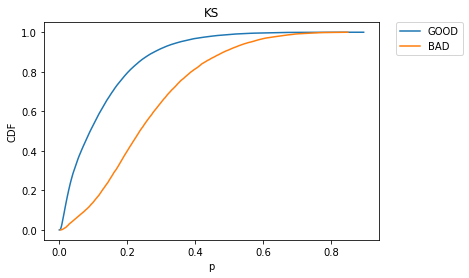

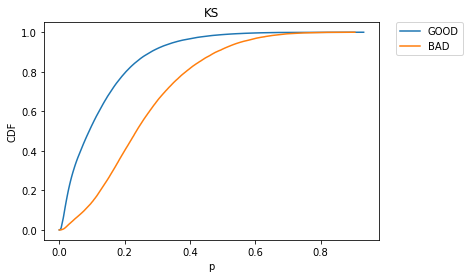

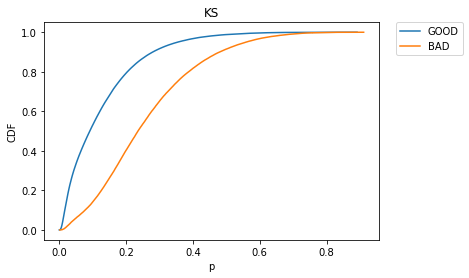

0.41995506772576646

In [41]:
# KS plotting
KS_compute_with_plot(prob=prob_tr, data_type=y_train_df['Y'])
KS_compute_with_plot(prob=prob_valid, data_type=y_valid_df['Y'])
KS_compute_with_plot(prob=prob_test, data_type=y_test_df['Y'])

### L2 regularization

In [42]:
l2_lambda = np.linspace(0.1, 1, num = 10).tolist()

In [43]:
l2_lambda = [0.001, 0.005, 0.01, 0.05] + l2_lambda

In [44]:
l2_lambda

[0.001,
 0.005,
 0.01,
 0.05,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [45]:
contents = {'l2_lambda', 
            'ks_trn', 'ks_val', 'ks_tst', 
            'ar_trn', 'ar_val', 'ar_tst', 
            'iv_trn', 'iv_val', 'iv_tst'}

In [46]:
performance_df = pd.DataFrame(columns = contents)
performance_df = performance_df[['l2_lambda', 
            'ks_trn', 'ks_val', 'ks_tst', 
            'ar_trn', 'ar_val', 'ar_tst']]

In [49]:
l2_result_dict = dict()
for l in l2_lambda:
    
    model = LogisticRegression(penalty='l2', 
                           solver='liblinear', 
                           C = l)
    
    # Fitting
    model.fit(X_train_df, y_train_df)
    
    # Predict probability
    prob_tr = model.predict_proba(X_train_df)
    prob_valid = model.predict_proba(X_valid_df)
    prob_test= model.predict_proba(X_test_df)
    
    # Compute KS/AR
    result_train = Performances(prob_tr[:, 1], y_train_df['Y'])
    result_valid = Performances(prob_valid[:, 1], y_valid_df['Y'])
    result_test = Performances(prob_test[:, 1], y_test_df['Y'])
    
    # update_dict
    update_dict = {'l2_lambda' : l,
                     'ks_trn' : result_train.ks,
                     'ks_val' : result_valid.ks,
                     'ks_tst' : result_test.ks,
                     'ar_trn' : result_train.ar,
                     'ar_val' : result_valid.ar,
                     'ar_tst' : result_test.ar}
    performance_df = performance_df.append(update_dict, ignore_index=True)

C:\Users\w10\example\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\w10\example\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\w10\example\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\w10\example\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [50]:
performance_df

l2_lambda     ks_trn     ks_val     ks_tst     ar_trn     ar_val  \
0       0.001  41.911158  41.943331  41.794914  55.391866  55.366540   
1       0.005  42.271635  42.094178  42.032701  55.754591  55.610596   
2       0.010  42.319499  42.094660  42.030707  55.836274  55.643451   
3       0.050  42.452642  42.104688  42.036077  55.912462  55.647355   
4       0.100  42.413856  42.121257  42.032754  55.924136  55.643276   
5       0.200  42.421885  42.118324  42.012248  55.930779  55.639895   
6       0.300  42.413086  42.124160  42.008544  55.933145  55.637633   
7       0.400  42.432736  42.116813  42.005162  55.934998  55.636907   
8       0.500  42.434788  42.113816  42.004841  55.935956  55.636181   
9       0.600  42.440743  42.111389  42.003123  55.935442  55.635832   
10      0.700  42.428833  42.111137  41.995384  55.937033  55.635149   
11      0.800  42.425922  42.108944  41.994340  55.937244  55.634784   
12      0.900  42.431409  42.111203  41.994892  55.937562  55.634389   
13      1.000  42.436439  42.113082  41.995507  55.937805  55.634109   

       ar_tst  
0   55.255429  
1   55.503454  
2   55.543641  
3   55.560225  
4   55.557901  
5   55.555122  
6   55.553107  
7   55.552132  
8   55.551355  
9   55.550788  
10  55.550053  
11  55.550248  
12  55.549784  
13  55.549420

In [51]:
result_path = r'C:\Users\w10\Code\교육'

In [52]:
performance_df.to_csv(os.path.join(result_path, 'Logistic_result_full.csv'), index = False)